## 1. 保存模型并打包整个流程，同时计算AUC并绘制ROC曲线

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

In [ ]:
# 加载数据
file_path = 'd:\\20241111_BC_cfDNA\\00_Backup\\BC_01_TD_features.xlsx'
data = pd.read_excel(file_path)

In [4]:
data = data.fillna(0)

In [ ]:
# 准备数据
X = data.iloc[:, 3:2206]  # 特征
y = data['status'].apply(lambda x: 1 if x == 'malignant' else 0)  # 将status转换为二进制
groups = data['SampleID']  # 组信息

In [6]:
print(f'Original X shape: {X.shape}')
print(f'Original y shape: {y.shape}')

Original X shape: (412, 9576)
Original y shape: (412,)


In [7]:
# from sklearn.impute import SimpleImputer

# # 用均值填补缺失值
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# X = X.dropna()
# y = y[X.index]

In [8]:
# 使用10折分层交叉验证
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [9]:
# 加载预训练模型
# model_svm = joblib.load('SVM.pkl')
# model_glm = joblib.load('logistic_regression.pkl')
# model_gbm = joblib.load('GradientBoostingClassifier.pkl')
model_lgbm = joblib.load('LGBMClassifier.pkl')
model_xgb = joblib.load('XGBClassifier.pkl')
# model_mlp = joblib.load('MLPClassifier_pipeline.pkl')

In [10]:
# 定义基础模型
estimators = [
    # ('svm', model_svm),  # svm
    # ('glm', model_glm), # GLM
    # ('gbm', model_gbm), # GBM
    ('lgbm', model_lgbm), # LightGBM
    ('xgb', model_xgb),   # XGBoost
    # ('mlp', model_mlp)   # XGBoost
]

In [11]:
# 定义堆叠模型，元模型为逻辑回归
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

In [12]:
# 创建Pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # 数据标准化
    ('stacked_model', stacked_model)  # 堆叠模型
])

In [13]:
# from sklearn.ensemble import VotingClassifier

# # 定义集成模型（Voting Classifier）
# voting_clf = VotingClassifier(
#     estimators=estimators,  # 传入你的基础模型
#     voting='soft'  # 'hard'表示多数表决，'soft'表示预测概率的加权平均
# )

# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # 先标准化数据
#     ('voting_clf', voting_clf)  # 再进行集成模型预测
# ])

# # 训练
# pipeline.fit(X_train, y_train)

# # 预测
# y_pred = pipeline.predict(X_test)

In [14]:
# 用于存储结果
accuracies = []
f1_scores = []
y_true_all = []
y_pred_all = []
y_prob_all = []
group_all = []

In [15]:
# 执行交叉验证
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 训练模型
    pipeline.fit(X_train, y_train)
    
    # 预测和评估
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # 获取预测为malignant的概率

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # 保存真实值、预测值、概率和组信息
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_prob_all.extend(y_prob)
    group_all.extend(groups.iloc[test_index])

    # 计算各项指标
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    
    TN, FP, FN, TP = cm.ravel()  # 根据数据调整解包顺序
    sensitivity = TP / (TP + FN)  # 同时也称为Recall
    specificity = TN / (TN + FP)
    ppv = TP / (TP + FP)  # 正预测值
    npv = TN / (TN + FN)  # 负预测值

    # 计算Benign和Malignant的数量
    benign_count = np.sum(y_test == 0)
    malignant_count = np.sum(y_test == 1)
    
    # 找出当Specificity = 0.9和0.95时的y_prob阈值
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # 查找特定的阈值
    threshold_90 = thresholds[np.argmax(fpr <= 0.1)]  # Specificity = 0.9
    threshold_95 = thresholds[np.argmax(fpr <= 0.05)] # Specificity = 0.95
    
    # 输出各项指标
    print(f'Fold Results:')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'AUC: {auc:.3f}')
    print(f'PPV: {ppv:.3f}')
    print(f'NPV: {npv:.3f}')
    print(f'Sensitivity: {sensitivity:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'Benign count: {benign_count}')
    print(f'Malignant count: {malignant_count}')
    print(f'y_prob threshold when Specificity=0.9: {threshold_90:.3f}')
    print(f'y_prob threshold when Specificity=0.95: {threshold_95:.3f}')
    print('-' * 40)

[LightGBM] [Info] Number of positive: 234, number of negative: 136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186398
[LightGBM] [Info] Number of data points in the train set: 370, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.632432 -> initscore=0.542666
[LightGBM] [Info] Start training from score 0.542666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [16]:
# 计算所有折的平均指标
average_accuracy = np.mean([accuracy_score(y_true_all, y_pred_all)])
average_auc = roc_auc_score(y_true_all, y_prob_all)
average_sensitivity = np.mean([sensitivity])
average_specificity = np.mean([specificity])
average_ppv = np.mean([ppv])
average_npv = np.mean([npv])

print(f'Overall Results:')
print(f'Average Accuracy: {average_accuracy:.3f}')
print(f'Average AUC: {average_auc:.3f}')
print(f'Average Sensitivity: {average_sensitivity:.3f}')
print(f'Average Specificity: {average_specificity:.3f}')
print(f'Average PPV: {average_ppv:.3f}')
print(f'Average NPV: {average_npv:.3f}')


Overall Results:
Average Accuracy: 0.888
Average AUC: 0.942
Average Sensitivity: 0.923
Average Specificity: 0.867
Average PPV: 0.923
Average NPV: 0.867


In [17]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay

# # 绘制综合ROC曲线
# fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
# roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=average_auc)
# roc_display.plot()

# plt.title('ROC Curve (All Folds Combined)')
# plt.show()

# results_df = pd.DataFrame({
#     'y_true': y_true_all,
#     'y_pred': y_pred_all,
#     'y_prob': y_prob_all,
#     'group': group_all
# })

# results_df.to_excel('cross_validation_results.csv', index=False)

In [18]:
# 显示平均结果
print("Average Accuracy:", sum(accuracies) / len(accuracies))
print("Average F1 Score:", sum(f1_scores) / len(f1_scores))

Average Accuracy: 0.8885017421602788
Average F1 Score: 0.915833701521715


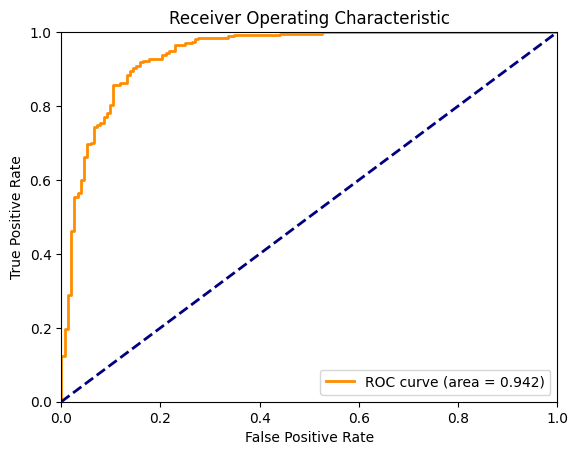

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)

# 使用roc_auc_score计算AUC
roc_auc = roc_auc_score(y_true_all, y_prob_all)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [20]:
# 保存Pipeline
pipeline_path = 'stacked_model.pkl'
joblib.dump(pipeline, pipeline_path)

print(f"Pipeline saved to: {pipeline_path}")

Pipeline saved to: stacked_model.pkl


In [21]:
# 创建包含预测结果和组信息的数据框
results_df = pd.DataFrame({
    'Group': group_all,
    'True Status': y_true_all,
    'Predicted Status': y_pred_all,
    'Malignant Probability': y_prob_all
})

# 输出到Excel文件
output_path = '01_prediction_results.xlsx'
results_df.to_excel(output_path, index=False)

# 打印输出文件路径和AUC值
print(f"Results saved to: {output_path}")
print(f"AUC: {roc_auc:.3f}")


Results saved to: 01_prediction_results.xlsx
AUC: 0.942


In [22]:
print(f'Original X shape: {X.shape}')
print(f'Original y shape: {y.shape}')

Original X shape: (412, 9576)
Original y shape: (412,)


[LightGBM] [Info] Number of positive: 234, number of negative: 136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186398
[LightGBM] [Info] Number of data points in the train set: 370, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.632432 -> initscore=0.542666
[LightGBM] [Info] Start training from score 0.542666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

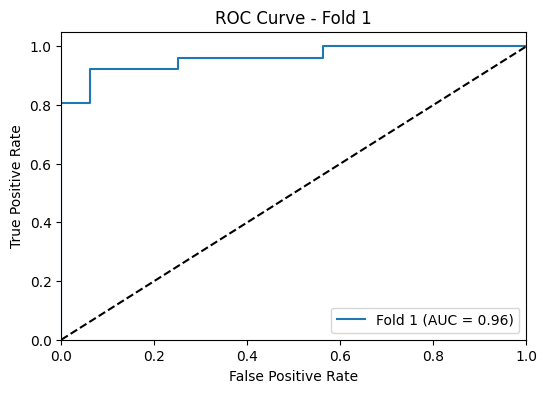

Saved fold_1.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186334
[LightGBM] [Info] Number of data points in the train set: 370, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.632432 -> initscore=0.542666
[LightGBM] [Info] Start training from score 0.542666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

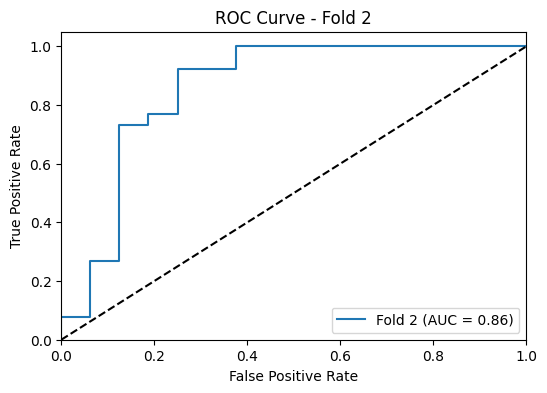

Saved fold_2.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189559
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

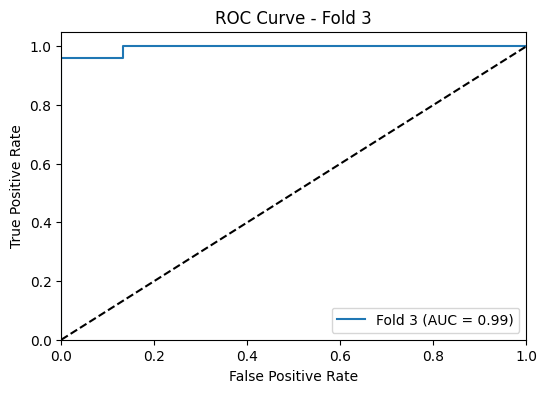

Saved fold_3.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189564
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

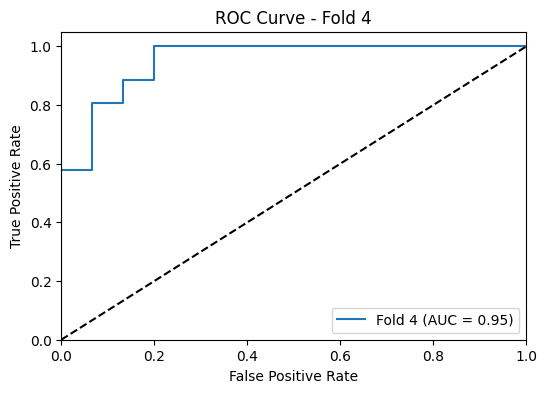

Saved fold_4.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189577
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

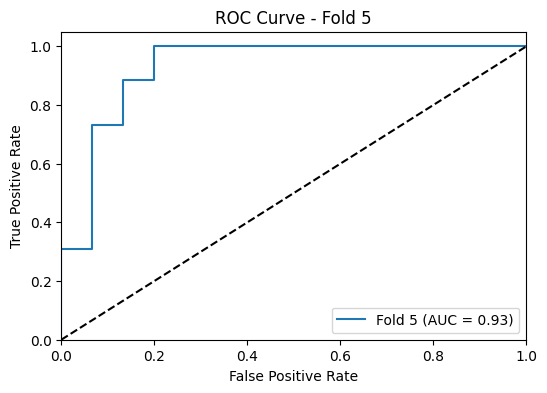

Saved fold_5.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189605
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

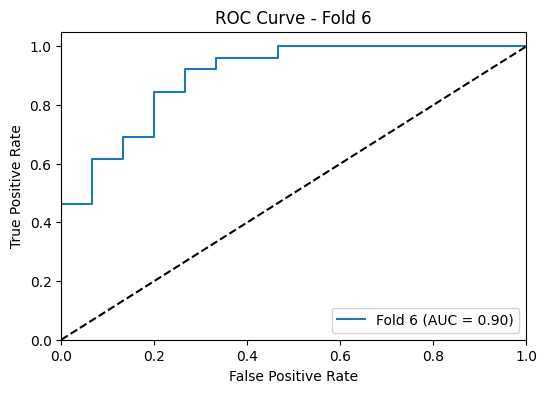

Saved fold_6.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189555
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

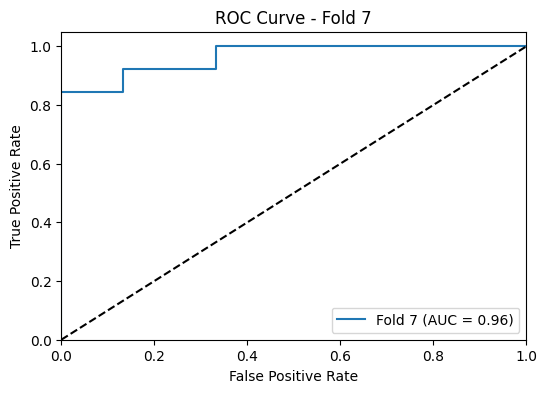

Saved fold_7.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189585
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

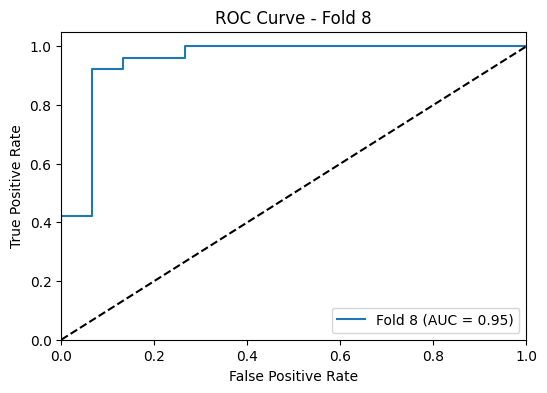

Saved fold_8.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189500
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

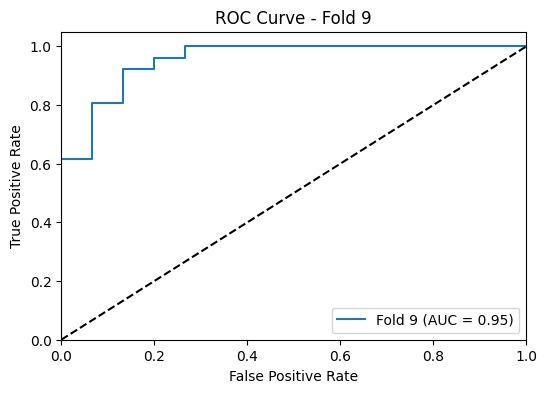

Saved fold_9.xlsx
[LightGBM] [Info] Number of positive: 234, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189599
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 9571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630728 -> initscore=0.535340
[LightGBM] [Info] Start training from score 0.535340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

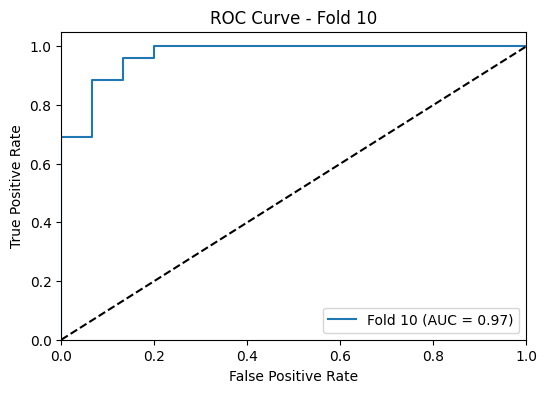

Saved fold_10.xlsx


In [23]:
from sklearn.model_selection import StratifiedKFold

# 创建 StratifiedKFold 对象，指定折数
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 循环交叉检验的每一折
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 在每一折上训练模型
    pipeline.fit(X_train, y_train)
    
    # 获取预测值和预测概率
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # 对于二分类问题，如果是多分类问题需要调整
    
    # 构建DataFrame并添加列
    test_data = pd.DataFrame({
        'y_pred': y_pred,
        'y_prob': y_prob,
        'y_true': y_test,
        'group': groups.iloc[test_index]
    })

    # 计算ROC曲线和AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # 绘制每一折的ROC曲线
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Fold {fold + 1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Fold {fold + 1}')
    plt.legend(loc='lower right')
    plt.show()
    
    # 保存为Excel文件
    file_name = f'fold_{fold + 1}.xlsx'
    test_data.to_excel(file_name, index=False)
    print(f'Saved {file_name}')


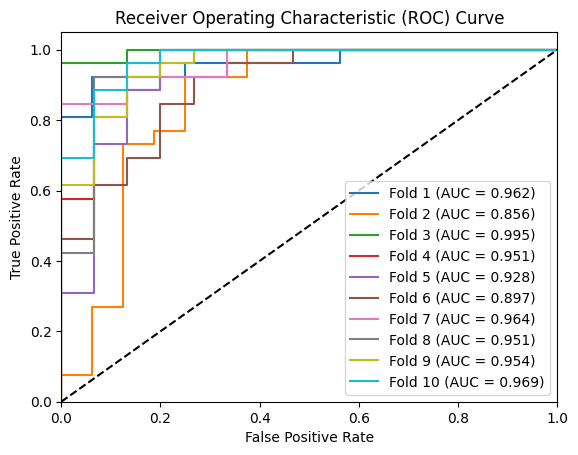

Average AUC: 0.943


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

auc_scores = []

for fold in range(10):
    try:
        # 读取每一折的真实值和预测概率
        df = pd.read_excel(f'fold_{fold + 1}.xlsx')
        y_true = df['y_true']
        y_prob = df['y_prob']
        
        # 计算 ROC 曲线
        fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        # 绘制 ROC 曲线
        plt.plot(fpr, tpr, label=f'Fold {fold + 1} (AUC = {roc_auc:.3f})')
    except Exception as e:
        print(f"Error processing fold {fold + 1}: {e}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 输出平均AUC
print(f'Average AUC: {np.mean(auc_scores):.3f}')

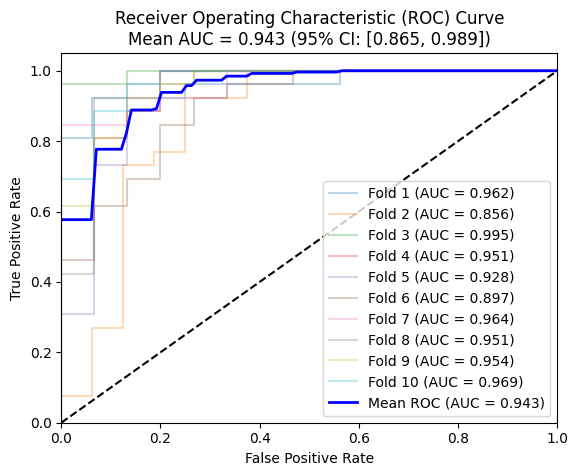

Average AUC: 0.943
95% CI for AUC: [0.865, 0.989]


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 用于保存每折的AUC和TPR值
auc_scores = []
mean_fpr = np.linspace(0, 1, 100)  # 生成0到1的100个等间隔的点，用于插值
tprs = []  # 保存每一折的TPR插值结果

for fold in range(10):
    try:
        # 读取每一折的真实值和预测分数
        df = pd.read_excel(f'fold_{fold + 1}.xlsx')
        y_true = df['y_true']
        y_prob = df['y_prob']
        
        # 计算 ROC 曲线
        fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        # 将每折的TPR插值到mean_fpr对应的FPR点上
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tprs.append(tpr_interp)
        
        # 绘制每折的ROC曲线
        plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {fold + 1} (AUC = {roc_auc:.3f})')
    except Exception as e:
        print(f"Error processing fold {fold + 1}: {e}")

# 计算TPR的平均值
mean_tpr = np.mean(tprs, axis=0)

# 计算平均AUC和95%置信区间
mean_auc = np.mean(auc_scores)
lower_ci = np.percentile(auc_scores, 2.5)
upper_ci = np.percentile(auc_scores, 97.5)

# 绘制平均ROC曲线
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.3f})', lw=2)

# 绘制随机猜测的参考线
plt.plot([0, 1], [0, 1], 'k--')

# 图的设置
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 在图中显示95%置信区间
plt.title(f'Receiver Operating Characteristic (ROC) Curve\nMean AUC = {mean_auc:.3f} (95% CI: [{lower_ci:.3f}, {upper_ci:.3f}])')

# 显示图例
plt.legend(loc='lower right')
plt.show()

# 输出平均AUC和95%置信区间
print(f'Average AUC: {mean_auc:.3f}')
print(f'95% CI for AUC: [{lower_ci:.3f}, {upper_ci:.3f}]')

## 2. 加载模型并预测新数据，同时计算AUC并绘制ROC曲线

In [26]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [27]:
# 加载保存的Pipeline
pipeline_path = 'stacked_model.pkl'
loaded_pipeline = joblib.load(pipeline_path)

In [ ]:
# 加载新的数据进行预测（假设已经有一个新的数据集）
new_data = pd.read_excel('d:\\20241111_BC_cfDNA\\00_Backup\\BC_02_IVD_features.xlsx')  # 示例数据集
new_data = new_data.fillna(0)

In [ ]:
# 准备数据
X_new = new_data.iloc[:, 3:2206]  # 提取新数据中的特征
groups_new = new_data['SampleID']  # 组信息
y_true_new = new_data['status'].apply(lambda x: 1 if x == 'malignant' else 0)  # 真实状态

In [30]:
# 使用加载的模型进行预测
y_pred_new = loaded_pipeline.predict(X_new)
y_prob_new = loaded_pipeline.predict_proba(X_new)[:, 1]  # 获取预测为malignant的概率

In [31]:
# 计算ROC曲线并绘制
fpr_new, tpr_new, thresholds_new = roc_curve(y_true_new, y_prob_new)
roc_auc_new = auc(fpr_new, tpr_new)

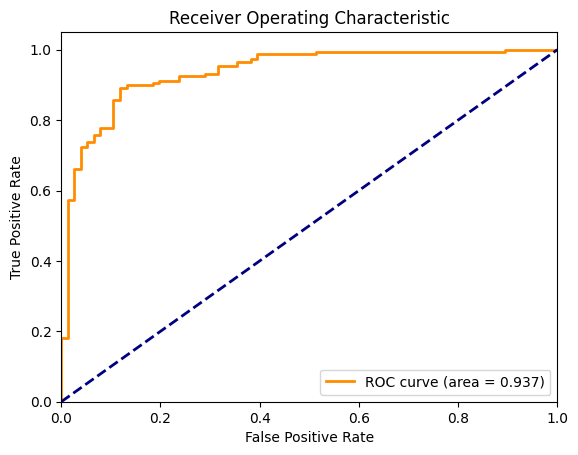

In [32]:
plt.figure()
plt.plot(fpr_new, tpr_new, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_new)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
# 创建包含预测结果和组信息的数据框
results_new_df = pd.DataFrame({
    'Group': groups_new,
    'True Status': y_true_new,
    'Predicted Status': y_pred_new,
    'Malignant Probability': y_prob_new
})

In [34]:
# 输出到Excel文件
output_new_path = '02_prediction_results.xlsx'
results_new_df.to_excel(output_new_path, index=False)

In [35]:
# 打印输出文件路径和AUC值
print(f"Results for new data saved to: {output_new_path}")
print(f"AUC for new data: {roc_auc_new:.3f}")

Results for new data saved to: 02_prediction_results.xlsx
AUC for new data: 0.937


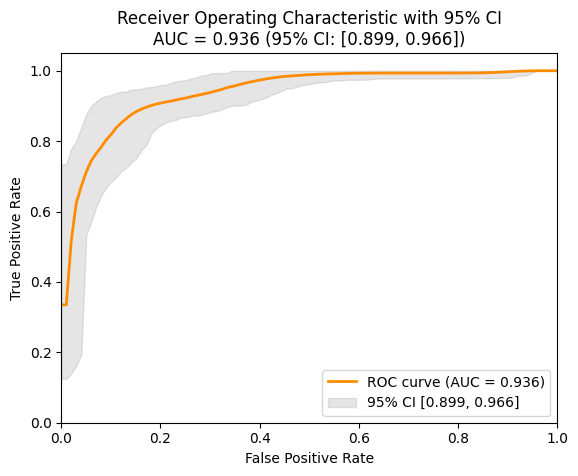

AUC: 0.936
95% CI for AUC: [0.899, 0.966]
Sensitivity: 0.932 (95% CI: [0.890, 0.972])
Specificity: 0.696 (95% CI: [0.593, 0.791])
PPV: 0.857 (95% CI: [0.805, 0.907])
NPV: 0.840 (95% CI: [0.742, 0.932])


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import resample

# 假设 y_true_new 是真实的标签，y_prob_new 是预测的概率
n_bootstraps = 1000
bootstrapped_aucs = []
mean_fpr = np.linspace(0, 1, 100)  # 生成0到1的100个等间隔的点
tprs = []  # 保存每次bootstrap的tpr

# 固定随机种子以确保可复现
rng = np.random.RandomState(42)

# 进行Bootstrap采样，计算AUC、ROC曲线以及敏感性、特异性、PPV、NPV
sensitivities = []
specificities = []
ppvs = []
npvs = []

# 定义一个阈值来将概率转化为二元分类结果，通常是0.5
threshold = 0.5

for i in range(n_bootstraps):
    # 有放回地进行采样
    indices = rng.randint(0, len(y_true_new), len(y_true_new))
    if len(np.unique(y_true_new[indices])) < 2:
        # 如果采样后的数据只有一个类，跳过本次计算
        continue
    
    y_true_bootstrap = y_true_new[indices]
    y_prob_bootstrap = y_prob_new[indices]
    
    # 计算ROC曲线
    fpr, tpr, _ = roc_curve(y_true_bootstrap, y_prob_bootstrap)
    
    # 使用插值将TPR插值到mean_fpr对应的FPR值上
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)
    
    # 计算AUC
    auc = roc_auc_score(y_true_bootstrap, y_prob_bootstrap)
    bootstrapped_aucs.append(auc)
    
    # 使用阈值0.5生成预测标签
    y_pred_bootstrap = (y_prob_bootstrap >= threshold).astype(int)
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_true_bootstrap, y_pred_bootstrap).ravel()
    
    # 计算Sensitivity, Specificity, PPV, NPV
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    ppvs.append(ppv)
    npvs.append(npv)

# 计算95%置信区间
sorted_auc_scores = np.sort(bootstrapped_aucs)
lower_bound_auc = np.percentile(sorted_auc_scores, 2.5)
upper_bound_auc = np.percentile(sorted_auc_scores, 97.5)

# 计算Sensitivity, Specificity, PPV, NPV的均值和置信区间
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_ppv = np.mean(ppvs)
mean_npv = np.mean(npvs)

ci_sensitivity = (np.percentile(sensitivities, 2.5), np.percentile(sensitivities, 97.5))
ci_specificity = (np.percentile(specificities, 2.5), np.percentile(specificities, 97.5))
ci_ppv = (np.percentile(ppvs, 2.5), np.percentile(ppvs, 97.5))
ci_npv = (np.percentile(npvs, 2.5), np.percentile(npvs, 97.5))

# 计算mean_tpr和95%置信区间
tprs = np.array(tprs)
mean_tpr = tprs.mean(axis=0)
std_tpr = tprs.std(axis=0)
tpr_lower = np.percentile(tprs, 2.5, axis=0)
tpr_upper = np.percentile(tprs, 97.5, axis=0)

# 绘制ROC曲线和95%置信区间
plt.figure()

# 主ROC曲线
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {np.mean(bootstrapped_aucs):.3f})')

# 绘制95%置信区间带
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.2, 
                 label=f'95% CI [{lower_bound_auc:.3f}, {upper_bound_auc:.3f}]')

# 图的基本设置
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic with 95% CI\nAUC = {np.mean(bootstrapped_aucs):.3f} (95% CI: [{lower_bound_auc:.3f}, {upper_bound_auc:.3f}])')

# 添加图例
plt.legend(loc="lower right")

# 显示图像
plt.show()

# 打印AUC及其95%置信区间
print(f"AUC: {np.mean(bootstrapped_aucs):.3f}")
print(f"95% CI for AUC: [{lower_bound_auc:.3f}, {upper_bound_auc:.3f}]")

# 打印Sensitivity, Specificity, PPV, NPV及其95%置信区间
print(f"Sensitivity: {mean_sensitivity:.3f} (95% CI: [{ci_sensitivity[0]:.3f}, {ci_sensitivity[1]:.3f}])")
print(f"Specificity: {mean_specificity:.3f} (95% CI: [{ci_specificity[0]:.3f}, {ci_specificity[1]:.3f}])")
print(f"PPV: {mean_ppv:.3f} (95% CI: [{ci_ppv[0]:.3f}, {ci_ppv[1]:.3f}])")
print(f"NPV: {mean_npv:.3f} (95% CI: [{ci_npv[0]:.3f}, {ci_npv[1]:.3f}])")